<a href="https://colab.research.google.com/github/Danial-sb/GNNs_on_Cora/blob/main/GNNs_on_CORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to perform three models (**MLP**, **GCN**, **and GraphSAGE**) 
using the Cora dataset for node prediction. As a result, we will be able to observe that applying graph neural networks yields much higher accuracy than simply using MLPs.

### **What is Cora?**

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

- Nodes = Publications
- Edges = Citations
- Node Features = word vectors (Bag of Words)
- 7 Labels = Pubilcation type

###### Source: https://paperswithcode.com/dataset/cora

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
print(torch.__version__)

1.12.1+cu113


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 26.1 MB/s 
     |████████████████████████████████| 3.5 MB 25.6 MB/s 


In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='./Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [4]:
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features in the dataset: {dataset.num_features}')
print(f'Number of classes in the dataset: {dataset.num_classes}')

Number of graphs in the dataset: 1
Number of features in the dataset: 1433
Number of classes in the dataset: 7


In [5]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of nodes that will be trained: {data.train_mask.sum()}')  #Available nodes for training.
print(f'{data.train_mask.sum()} out of {data.num_nodes} are trainable.')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of nodes that will be trained: 140
140 out of 2708 are trainable.


In [6]:
data.x[0, :50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [7]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [8]:
#adjacency information
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [9]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lin1 = torch.nn.Linear(input_size, hidden_size)
    self.lin2 = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = F.dropout(x, p=0.2, training=self.training)
    x = self.lin2(x)

    return x

In [ ]:
model_mlp = MLP(dataset.num_features, 32, dataset.num_classes)
print(model_mlp)

MLP(
  (lin1): Linear(in_features=1433, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=7, bias=True)
)


In [93]:
model_mlp = MLP(dataset.num_features, 32, dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model_mlp.train()
      optimizer.zero_grad()
      out = model_mlp(data.x)
      # Compute loss on trainable nodes (mask)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      pred = out.argmax(dim=1)
      correct = pred[data.train_mask] == data.y[data.train_mask]
      acc = int(correct.sum()) / int(data.train_mask.sum())
      val_correct = pred[data.val_mask] == data.y[data.val_mask]
      val = int(val_correct.sum()) / int(data.val_mask.sum())
      return acc, loss, val

def test():
      model_mlp.eval()
      out = model_mlp(data.x)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
accuracy = []
val_accuracy = []
for epoch in range(0, 201):
    acc, loss, val = train()
    losses.append(loss)
    accuracy.append(acc)
    val_accuracy.append(val)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train_acc: {acc:.4f}, val_accuracy: {val:.4f}')

Epoch: 0, Loss: 1.9524, Train_acc: 0.1500, val_accuracy: 0.2940
Epoch: 10, Loss: 1.8296, Train_acc: 0.9143, val_accuracy: 0.3140
Epoch: 20, Loss: 1.5293, Train_acc: 0.9786, val_accuracy: 0.3840
Epoch: 30, Loss: 1.0685, Train_acc: 0.9929, val_accuracy: 0.4580
Epoch: 40, Loss: 0.6953, Train_acc: 0.9857, val_accuracy: 0.4820
Epoch: 50, Loss: 0.3966, Train_acc: 1.0000, val_accuracy: 0.4960
Epoch: 60, Loss: 0.2807, Train_acc: 1.0000, val_accuracy: 0.5180
Epoch: 70, Loss: 0.2600, Train_acc: 0.9929, val_accuracy: 0.5080
Epoch: 80, Loss: 0.2466, Train_acc: 0.9929, val_accuracy: 0.5040
Epoch: 90, Loss: 0.2060, Train_acc: 1.0000, val_accuracy: 0.5160
Epoch: 100, Loss: 0.1760, Train_acc: 1.0000, val_accuracy: 0.5340
Epoch: 110, Loss: 0.1634, Train_acc: 1.0000, val_accuracy: 0.5440
Epoch: 120, Loss: 0.1519, Train_acc: 1.0000, val_accuracy: 0.5060
Epoch: 130, Loss: 0.1510, Train_acc: 1.0000, val_accuracy: 0.5560
Epoch: 140, Loss: 0.1284, Train_acc: 1.0000, val_accuracy: 0.5480
Epoch: 150, Loss: 0.1

In [94]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5990


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


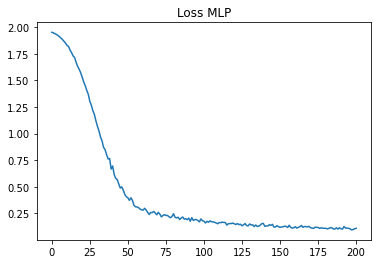

In [95]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)] 
sns.lineplot(loss_indices, losses_float)
plt.title("Loss MLP")
plt.show()

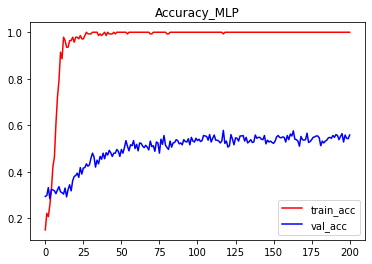

In [96]:
plt.plot(accuracy, c = 'red', label = "train_acc")
plt.plot(val_accuracy, c = 'blue', label = "val_acc")
plt.legend()
plt.title("Accuracy_MLP")
plt.show()

In [62]:
from torch_geometric.nn.conv.gcn_conv import GCNConv
from torch.nn import BatchNorm1d

class GCN(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
     super(GCN, self).__init__()
     
     self.input_size = input_size
     self.hidden_size = hidden_size
     self.output_size = output_size

     self.conv1 = GCNConv(input_size, hidden_size)
     self.bn1 = BatchNorm1d(hidden_size)
     self.conv2 = GCNConv(hidden_size, hidden_size)
     
     self.lin = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x, edge_index):

     x = self.conv1(x, edge_index)
     x = F.relu(self.bn1(x))
     x = F.dropout(x, 0.2, training=self.training)
    
     x = self.conv2(x, edge_index)
     x = F.relu(x)
     x = F.dropout(x, 0.2, training=self.training)

     x = self.lin(x)

     x = F.softmax(x, dim = 1)

     return x

In [53]:
model_gcn = GCN(dataset.num_features, 32, dataset.num_classes)
print(model_gcn)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=7, bias=True)
)


In [89]:
model_gcn = GCN(dataset.num_features, 16, dataset.num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_gcn = model_gcn.to(device)
data = data.to(device)

learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=learning_rate, weight_decay=decay)

criterion = torch.nn.CrossEntropyLoss()

def train():
      model_gcn.train()
      optimizer.zero_grad() 
      out = model_gcn(data.x, data.edge_index)  
      # we use mask cuz we want nodes with labels for loss calculation (trainable nodes)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      pred = out.argmax(dim=1)
      correct = pred[data.train_mask] == data.y[data.train_mask]
      acc = int(correct.sum()) / int(data.train_mask.sum())
      val_correct = pred[data.val_mask] == data.y[data.val_mask]
      val = int(val_correct.sum()) / int(data.val_mask.sum())
      return acc, loss, val

def test_gcn():
      model_gcn.eval()
      out = model_gcn(data.x, data.edge_index)
      #highest probability in the class.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
accuracy = []
val_accuracy = []
for epoch in range(0, 201):
    acc, loss, val = train()
    losses.append(loss)
    accuracy.append(acc)
    val_accuracy.append(val)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train_acc: {acc:.4f}, val_accuracy: {val:.4f}')

Epoch: 0, Loss: 1.9437, Train_acc: 0.1571, val_accuracy: 0.1440
Epoch: 10, Loss: 1.5517, Train_acc: 0.8143, val_accuracy: 0.4980
Epoch: 20, Loss: 1.3143, Train_acc: 0.9286, val_accuracy: 0.5860
Epoch: 30, Loss: 1.2312, Train_acc: 0.9500, val_accuracy: 0.6240
Epoch: 40, Loss: 1.2161, Train_acc: 0.9571, val_accuracy: 0.6440
Epoch: 50, Loss: 1.1767, Train_acc: 0.9929, val_accuracy: 0.6400
Epoch: 60, Loss: 1.1945, Train_acc: 0.9857, val_accuracy: 0.6780
Epoch: 70, Loss: 1.1743, Train_acc: 1.0000, val_accuracy: 0.6680
Epoch: 80, Loss: 1.1908, Train_acc: 0.9857, val_accuracy: 0.6920
Epoch: 90, Loss: 1.1934, Train_acc: 0.9786, val_accuracy: 0.6980
Epoch: 100, Loss: 1.1924, Train_acc: 0.9857, val_accuracy: 0.6340
Epoch: 110, Loss: 1.1841, Train_acc: 0.9929, val_accuracy: 0.6300
Epoch: 120, Loss: 1.1911, Train_acc: 0.9857, val_accuracy: 0.6420
Epoch: 130, Loss: 1.1771, Train_acc: 0.9929, val_accuracy: 0.6680
Epoch: 140, Loss: 1.1704, Train_acc: 1.0000, val_accuracy: 0.7100
Epoch: 150, Loss: 1.1

In [90]:
test_acc = test_gcn()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7540


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


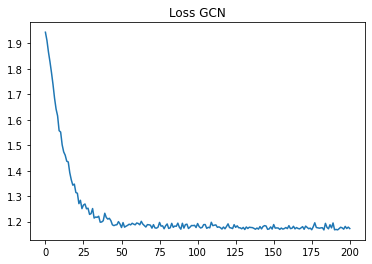

In [91]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)] 
sns.lineplot(loss_indices, losses_float)
plt.title("Loss GCN")
plt.show()

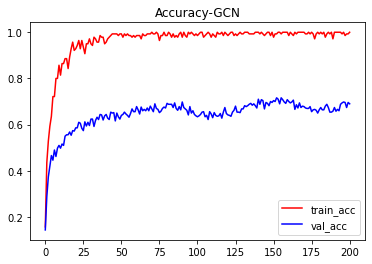

In [92]:
plt.plot(accuracy, c = 'red', label = "train_acc")
plt.plot(val_accuracy, c = 'blue', label = "val_acc")
plt.legend()
plt.title("Accuracy-GCN")
plt.show()

In [72]:
from torch_geometric.nn.conv import SAGEConv

class GraphSAGE(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GraphSAGE, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    #default aggregarion = mean
    self.sage1 = SAGEConv(input_size, hidden_size, normalize = True)
    self.sage2 = SAGEConv(hidden_size, hidden_size, normalize = True)
    self.lin = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x, edge_index):
    x = self.sage1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.2, training=self.training)
    x = self.sage2(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.2, training=self.training)
    x = self.lin(x)

    x = F.softmax(x, dim = 1)

    return x

In [66]:
model_sage = GraphSAGE(dataset.num_features, 16, dataset.num_classes)
print(model_sage)

GraphSAGE(
  (sage1): SAGEConv(1433, 16, aggr=mean)
  (sage2): SAGEConv(16, 16, aggr=mean)
  (lin): Linear(in_features=16, out_features=7, bias=True)
)


In [81]:
model_sage = GraphSAGE(dataset.num_features, 26, dataset.num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_sage = model_sage.to(device)
data = data.to(device)

learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model_sage.parameters(), lr=learning_rate, weight_decay=decay)

criterion = torch.nn.CrossEntropyLoss()

def train():
      model_sage.train()
      optimizer.zero_grad() 
      out = model_sage(data.x, data.edge_index)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      pred = out.argmax(dim=1)
      correct = pred[data.train_mask] == data.y[data.train_mask]
      acc = int(correct.sum()) / int(data.train_mask.sum())
      val_correct = pred[data.val_mask] == data.y[data.val_mask]
      val = int(val_correct.sum()) / int(data.val_mask.sum())
      return acc, loss, val

def test_sage():
      model_sage.eval()
      out = model_sage(data.x, data.edge_index)
      pred = out.argmax(dim=1)  
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
accuracy = []
val_accuracy = []
for epoch in range(0, 201):
    acc, loss, val = train()
    losses.append(loss)
    accuracy.append(acc)
    val_accuracy.append(val)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train_acc: {acc:.4f}, val_accuracy: {val:.4f}')

Epoch: 0, Loss: 1.9465, Train_acc: 0.1143, val_accuracy: 0.1440
Epoch: 10, Loss: 1.8748, Train_acc: 0.8857, val_accuracy: 0.4120
Epoch: 20, Loss: 1.7887, Train_acc: 0.9786, val_accuracy: 0.6740
Epoch: 30, Loss: 1.7059, Train_acc: 0.9929, val_accuracy: 0.7100
Epoch: 40, Loss: 1.5850, Train_acc: 1.0000, val_accuracy: 0.7280
Epoch: 50, Loss: 1.4756, Train_acc: 1.0000, val_accuracy: 0.7280
Epoch: 60, Loss: 1.4031, Train_acc: 1.0000, val_accuracy: 0.7580
Epoch: 70, Loss: 1.3362, Train_acc: 1.0000, val_accuracy: 0.7280
Epoch: 80, Loss: 1.3061, Train_acc: 1.0000, val_accuracy: 0.7360
Epoch: 90, Loss: 1.2819, Train_acc: 1.0000, val_accuracy: 0.7040
Epoch: 100, Loss: 1.2722, Train_acc: 1.0000, val_accuracy: 0.7020
Epoch: 110, Loss: 1.2626, Train_acc: 1.0000, val_accuracy: 0.7100
Epoch: 120, Loss: 1.2481, Train_acc: 1.0000, val_accuracy: 0.7180
Epoch: 130, Loss: 1.2412, Train_acc: 1.0000, val_accuracy: 0.7140
Epoch: 140, Loss: 1.2350, Train_acc: 0.9929, val_accuracy: 0.6920
Epoch: 150, Loss: 1.2

In [86]:
test_acc = test_sage()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7840


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


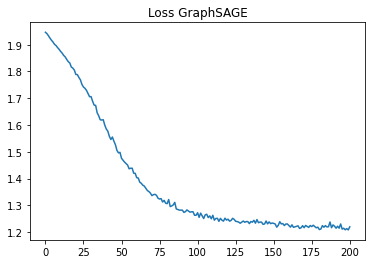

In [87]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)] 
sns.lineplot(loss_indices, losses_float)
plt.title("Loss GraphSAGE")
plt.show()

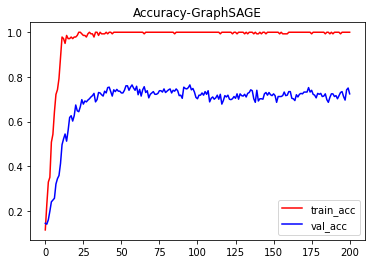

In [88]:
plt.plot(accuracy, c = 'red', label = "train_acc")
plt.plot(val_accuracy, c = 'blue', label = "val_acc")
plt.legend()
plt.title("Accuracy-GraphSAGE")
plt.show()

It was shown that for the given problem, GraphSAGE outperformed MLP and GCN in predicting the test data, achieving 78% accuracy compared to 75% and 59%, respectively.

For improving performance, approaches such as hyperparameter tuning, cross-validation, and other GNN methods can be implemented.